In [1]:
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mp
import matplotlib.animation as animation
import IPython

In [2]:
MASS = 0.600 # mass of the quadrotor
INERTIA = 0.15 # inertia of the quadrotor
        
LENGTH = 0.2 # length of the quadrotor
        
GRAVITY=9.81 #gravity constant

DELTA_T = 0.01 #integration step
        
NUMBER_STATES = 6 # number of states
NUMBER_CONTROLS = 2 # number of controls

In [3]:
def get_next_state(z,u):
    """
    Inputs:
    z: state of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    u: control as a numpy array (u1, u2)

    Output:
    the new state of the quadrotor as a numpy array
    """
    x = z[0]
    vx = z[1]
    y = z[2]
    vy = z[3]
    theta = z[4]
    omega = z[5]

    dydt = np.zeros([NUMBER_STATES,])
    dydt[0] = vx
    dydt[1] = (-(u[0] + u[1]) * np.sin(theta)) / MASS
    dydt[2] = vy
    dydt[3] = ((u[0] + u[1]) * np.cos(theta) - MASS * GRAVITY) / MASS
    dydt[4] = omega
    dydt[5] = (LENGTH * (u[0] - u[1])) / INERTIA

    z_next = z + dydt * DELTA_T

    return z_next

In [4]:
def simulate(z0, controller, horizon_length, disturbance = False):
    """
    This function simulates the quadrotor for horizon_length steps from initial state z0

    Inputs:
    z0: the initial conditions of the quadrotor as a numpy array (x, vx, y, vy, theta, omega)
    controller: a function that takes a state z as argument and index i of the time step and returns a control u
    horizon_length: the horizon length

    disturbance: if True will generate a random push every seconds during the simulation

    Output:
    t[time_horizon+1] contains the simulation time
    z[4, time_horizon+1] and u[2, time_horizon] containing the time evolution of states and control
    """
    
    t = np.zeros([horizon_length+1,])
    z=np.empty([NUMBER_STATES, horizon_length+1])
    z[:,0] = z0
    u=np.zeros([NUMBER_CONTROLS, horizon_length])
    for i in range(horizon_length):
        u[:,i] = controller(z[:,i],i)
        z[:,i+1] = get_next_state(z[:,i], u[:,i])
        if disturbance and np.mod(i,100)==0:
            dist = np.zeros([NUMBER_STATES, ])
            dist[1::2] = np.random.uniform(-1.,1,(3,))
            z[:,i+1] += dist
        t[i+1] = t[i] + DELTA_T
    return t, z, u

In [5]:
def animate_robot(x, u, dt = 0.01):
    """
    This function makes an animation showing the behavior of the quadrotor
    takes as input the result of a simulation (with dt=0.01s)
    """

    min_dt = 0.1
    if(dt < min_dt):
        steps = int(min_dt/dt)
        use_dt = int(np.round(min_dt * 1000))
    else:
        steps = 1
        use_dt = int(np.round(dt * 1000))

    #what we need to plot
    plotx = x[:,::steps]
    plotx = plotx[:,:-1]
    plotu = u[:,::steps]

    fig = mp.figure.Figure(figsize=[8.5,8.5])
    mp.backends.backend_agg.FigureCanvasAgg(fig)
    ax = fig.add_subplot(111, autoscale_on=False, xlim=[-4,4], ylim=[-4,4])
    ax.grid()

    list_of_lines = []

    #create the robot
    # the main frame
    line, = ax.plot([], [], 'k', lw=6)
    list_of_lines.append(line)
    # the left propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the right propeller
    line, = ax.plot([], [], 'b', lw=4)
    list_of_lines.append(line)
    # the left thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)
    # the right thrust
    line, = ax.plot([], [], 'r', lw=1)
    list_of_lines.append(line)

    def _animate(i):
        for l in list_of_lines: #reset all lines
            l.set_data([],[])

        theta = plotx[4,i]
        x = plotx[0,i]
        y = plotx[2,i]
        trans = np.array([[x,x],[y,y]])
        rot = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])

        main_frame = np.array([[-LENGTH, LENGTH], [0,0]])
        main_frame = rot @ main_frame + trans 

        left_propeller = np.array([[-1.3 * LENGTH, -0.7*LENGTH], [0.1,0.1]])
        left_propeller = rot @ left_propeller + trans

        right_propeller = np.array([[1.3 * LENGTH, 0.7*LENGTH], [0.1,0.1]])
        right_propeller = rot @ right_propeller + trans

        left_thrust = np.array([[LENGTH, LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        left_thrust = rot @ left_thrust + trans

        right_thrust = np.array([[-LENGTH, -LENGTH], [0.1, 0.1+plotu[0,i]*0.04]])
        right_thrust = rot @ right_thrust + trans

        list_of_lines[0].set_data(main_frame[0,:], main_frame[1,:])
        list_of_lines[1].set_data(left_propeller[0,:], left_propeller[1,:])
        list_of_lines[2].set_data(right_propeller[0,:], right_propeller[1,:])
        list_of_lines[3].set_data(left_thrust[0,:], left_thrust[1,:])
        list_of_lines[4].set_data(right_thrust[0,:], right_thrust[1,:])

        return list_of_lines

    def _init():
        return _animate(0)


    ani = animation.FuncAnimation(fig, _animate, np.arange(0, len(plotx[0,:])),
        interval=use_dt, blit=True, init_func=_init)
    plt.close(fig)
    plt.close(ani._fig)
    IPython.display.display_html(IPython.core.display.HTML(ani.to_html5_video()))

## Part 2 - LQR to stay in place

In [6]:
def get_linearization(z, u):
    A = np.array([[1, DELTA_T, 0, 0, 0, 0], 
                  [0, 1, 0, 0, (-1 * DELTA_T * (u[0] + u[1]) * np.cos(z[4])) / MASS, 0], 
                  [0, 0, 1, DELTA_T, 0, 0], 
                  [0, 0, 0, 1, (-1 * DELTA_T * (u[0] + u[1]) * np.sin(z[4])) / MASS, 0], 
                  [0, 0, 0, 0, 1, DELTA_T], 
                  [0, 0, 0, 0, 0, 1]])

    B = np.array([[0, 0],
                  [(-1 * DELTA_T * np.sin(z[4])) / MASS, (-1 * DELTA_T * np.sin(z[4])) / MASS],
                  [0, 0],
                  [(DELTA_T * np.cos(z[4])) / MASS, (DELTA_T * np.cos(z[4])) / MASS],
                  [0, 0],
                  [(DELTA_T * (LENGTH / INERTIA)), (DELTA_T * (-1 * (LENGTH / INERTIA)))]])
    
    return A, B

In [7]:
def solve_LQR(A, B, Q, R, N):
    list_of_P = []
    list_of_K = []
    idx = 0
    for i in range(N, -1, -1):
        if (i == N):
            list_of_P.append(Q) 
        else:
            k = -1 * ((np.linalg.inv((np.transpose(B) @ list_of_P[idx] @ B) + R)) @ np.transpose(B) @ list_of_P[idx] @ A)
             
            p = Q + np.transpose(A) @ list_of_P[idx] @ A + np.transpose(A) @ list_of_P[idx] @ B @ k
            
            list_of_K.append(k)
            list_of_P.append(p)
            idx += 1
    
    list_of_K.reverse()
    list_of_P.reverse()

    return list_of_P, list_of_K

In [8]:
z_star = np.array([0, 0, 0, 0, 0, 0])
u_star = np.array([((MASS * GRAVITY) / 2), ((MASS * GRAVITY) / 2)])

A, B = get_linearization(z_star, u_star)
horizon_length = 1000
Q = 50000 * np.eye(NUMBER_STATES)
R = 0.01 * np.eye(NUMBER_CONTROLS)

P, K_gains = solve_LQR(A, B, Q, R, horizon_length)

In [9]:
def controller_P2(state, i):
    u = u_star + (K_gains[i] @ state)
    return u

In [10]:
t, state, u = simulate(z_star, controller_P2, horizon_length, disturbance = True)
animate_robot(state, u, dt = 0.01)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAXZdtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABLBZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKH8XjN/AAAAwAAt4AXsAwgCqgMKj6I
dndnTzAIiR6+OnDbVkTjpPexGHLjoXY30hkXEhSE9kEKIJNbrApCI4G73ihHZi4T1K1iog5Wc0p6
pLHThCwCmnYhSqYpYbTo2n5tZjl9Sersc3rmxTCU1aG5ejWlf2ZiBPtJ6vuZEf6FCWPekrjf3iOx
g9nYeAC3//ekaJ6Uup8pEnX74AtF5miPCXmGYp1VgIlMhblKE1f5XLlxb1HUXmuG+fEgDCAJNggr
SWMoFVS8OFpaDDMvSO64pmzh6vHDoKtfmcA4i12uUsh7rwNZe/BI7LdbaaCmFlaKG6p3WlZZBOgL
c6Xh6KGqBk+DXTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlIHYXCzI57hN1GXk5AJs78
kL3L0uFeE8COidDOFd4yzkoe/7l2h6wEKOz7uFgABdAAABgT/XL0eR8k6J3lRIGcTlhh/LgQemvB
9LeOOPbS/io9bEKpktMzUsr2rH7n7gn+AW5ayX7+OPXTsJWi5Af6cl+Qnz0uW+DYBLS5p2thXpov
CDk56tcwW0pgAmn5ff2hXXmI9LQE3pWGz9avZjnRjG4VNxvRD6MJBuoGFZz0TZh4HejXX+Xr6AY1
NtLhG5Dt0FFT7heDy2T/J56stCiLolYaEC4Lsf3Ba/m1qzWfMEIyANp7aDPKoMHvT9ZjAKv7FBZX
Xxf0d3g8dTn4pTf1GQPGRmfytUQyQGmaJAtChL15m3Bfb2TtW1+3gzSZ1S1Rg4BH5ZPE24z39rF9
EoPALouyjq/tksmA0xnvlOq2NQQ7nQGy++HnWaMv68jeZLfIspnHkGYLlaiHH8+7/gxXkppoqbbV
zGkbOLAlUxuB3Hkcp5ozwRFJEkffYokAAAMAAAMAAAMAAAU6K2WUArTaxeJ+FAI6eDOlC41QrK3f
HaPOA6Tkh7/DwxsYaebi6Zz/tc3X0+AhNf+/w/jFcrRNyaPOOEcBzxEuEPILst0ElfjGP5v3AH5X
yXBfc7WidnYCZrsawbrLqWTm4QgoAdRgLV0U555i/86kNOiHr46Nw6torKk1r7mNtZ/T/Xe6+E7+
EjZHG90CyaEPaGS3j/5mYHg3MA5rbEmvPGuisLgNZSWC1YVoTVeDeOdKGR4E2btWR6qv3qENxUyo
8iZFN4bCV4sg7yVTfCv+Q1WwrD7TEkA1RBJAbcuHVY/8Cr9g1yT55JNil2P/LNaXYUIQw3dbuA0A
Pk8XHLIUBKF97ZANsF7aGYwAx5/lXZ4VehoU4xcE8RhlLFM4cpp+d+Knot6APk5kCQAAbt3cswf9
8VQgESJkJJAA+SWSIQAb8pg7QEFCMiI9fXlA5RchbcN6cnpCg4tPCQQUQzEYuMw5TSwFBoseTShV
DvUG8HqMeInlNnSc35dg6qXdjP7Eua7hazlhmTTc0VS9ZoYRvwPFL4tfuY06N4iDUZjIQbg7U70s
URUHGExDjY1GOP+WaHftiuowiY2wZc2zZBbJN6IPGA+CheMfDJvd1NLOEP0ozXYw03vnZs/W9gCx
b1e23z/vXgKv7enJbogTUHDv4z1gABhP1/SXYHRQsyIRRJnZQHPe5lQLlhk7ZJsEYIzSVMlJeek+
SyiSt0lurw+wWSMU6ek23ZY+4t+OO+LOBc440+D65iGCaY12Mo62QSRuIyOPrpSHL1Ms/r+T68E5
hrb4xy99bkV2XzIsD5hKbX839f5IRid5vjrFQYrfEsU5YFsMypirxPu/i9/x3QEKO7zbBAbohpDn
Rqx2iDHSG7RQWmLnXQao9tuKp39+CkmlVmj82HVHfDMpLDoblqsXfKEhlIgACqXnqzZ35nAAAKTX
1U9rRsiAC5V8ghrJ9azIfJ30xx37EuZVgyev1zaxxgi4Qn7DiBlvjZ7BH0+Hmpgj3wiMqyiTuxad
HfLI1WRlmg9s6QwFDM0USHrfrhriqRxG9H2piEEke+wAQbs5yn4b+3f/q32vU5s/ZJTzRbDos27c
TqzEgq7/KgXgv+CZrXTvYsRqGuR6stlSCRwQvkWWZZSd6BC7zqoCLmZ1FWeO0wYPTV7R3bJGRjqe
gEUE9LeRw5lfrn38loioIezAXhYoMtqj8IORoP2pWFdSiMGjU1R/yyX0rIqcCthaMVSnazpUUddL
VGdTNwI20xVt5Xr5PX9CC1jn58JppdFtpKtMiz4l2Fm7vOolFBoBWF/m0pSw7iIUC/YPn+MQ/hbI
0GPtQkQZGQml2ozQUMMJde03v0mNpUt8Hpxpy5fTXu7znoiaIAO20WkDl8AlNfsH3Dlpd2cC2vDt
CcfCv5GeBU29Bilb3JaoY2iTYWQDcH6vbdd3Y9VC9bPrh6qPgOycd19nIikZXTiQVXlMw81Q87zV
D2JBYfQYaJUFbTxu1PvD+arK56rbHYfmlo6mN5gjiqCDEIhxz2E9pA5VCTKJ7PCNSXi5mPVg802Y
xoDUHssZhEc6uOPOYTNoRKjzScMknWrS0z3Zlu2UUJbdSnNorrrWQD1f6dYL42rpysPmN+gCGvtx
yp6B5R2L7Dz+4DGjbjzl7n/RsUGSLvuJetXzmmsJ1dYCAKrsRD2tukeltdKWwAIXQG1fYHV9ABNm
FUUNNB518JBr/zeA2CSVBAqEl/HA4+vyIneC7iSJut4zJBiefY+QXGcr3Y6p0X/a6/9RMre+iWax
lmBZhSIu1QsSGK5qQXY0owoi298RBA9YCOHokx2rIneXX5hHX6WerPyuuaOAEwIsGN/NoDpUeSI3
YoG2XCrFUC1SwqPdC0uAAAAzpzVvUxSYb3Cv5mfriQAAAwAAAwDls0vAKLn9XiTukJyrcM8awmw9
EouO8SO97hWOMkE1vIBF1

Text(0.5, 0, 'Time [s]')

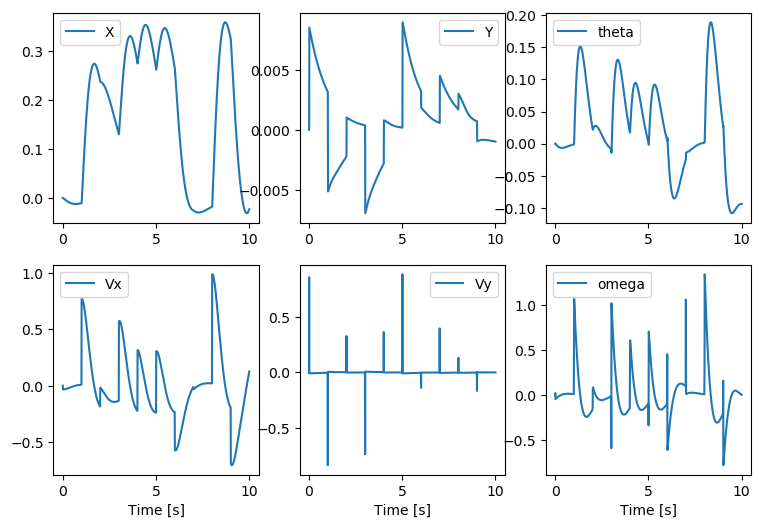

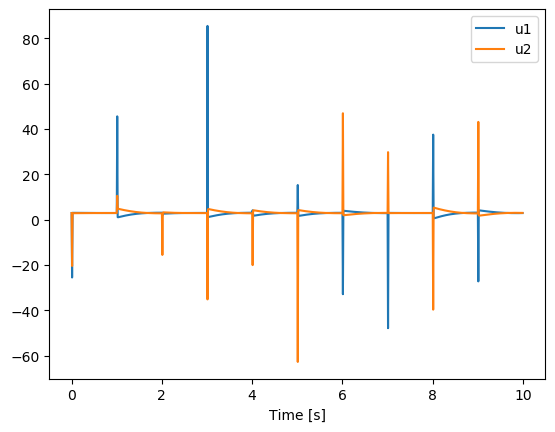

In [11]:
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

## Part 3 - following a trajectory using linearized dynamics

In [12]:
def solve_LQR_trajectory(A, B, Q, R, x_bar, N):
    K_gains = []
    k_feedforward = []
    list_of_P = []
    list_of_p = []

    idx = 0
    for i in range(N, -1, -1):
        if (i == N):
            list_of_P.append(Q)
            q = -1 * (Q @ x_bar)
            list_of_p.append(q[:, i])

        else:
            K = -1 * (np.linalg.inv(R + np.transpose(B[i]) @ list_of_P[idx] @ B[i])) @ np.transpose(B[i]) @ list_of_P[idx] @ A[i]
             
            P = Q + np.transpose(A[i]) @ list_of_P[idx] @ A[i] + np.transpose(A[i]) @ list_of_P[idx] @ B[i] @ K

            k = -1 * (np.linalg.inv(R + np.transpose(B[i]) @ list_of_P[idx] @ B[i])) @ np.transpose(B[i]) @ list_of_p[idx]

            p = q[:, i] + np.transpose(A[i]) @ list_of_p[idx] + np.transpose(A[i]) @ list_of_P[idx] @ B[i] @ k
            
            list_of_p.append(p)
            list_of_P.append(P)

            K_gains.append(K)
            k_feedforward.append(k)
            idx += 1
    
    
    K_gains.reverse()
    k_feedforward.reverse()
    
    return K_gains, k_feedforward

In [13]:
t = np.arange(0, 10.01, DELTA_T)
N = len(t) - 1

Q = np.diag([2500, 750, 2500, 750, 250, 0])
R = 0.01 * np.eye(NUMBER_CONTROLS)

u_star = np.zeros((NUMBER_CONTROLS, N))
r_u = u_star.shape[0]
c_u = u_star.shape[1]
for i in range(r_u):
    for j in range(c_u):
        u_star[i, j] = ((MASS * GRAVITY) / 2)

z_star = np.zeros((NUMBER_STATES, N + 1))
r_z = z_star.shape[0]
c_z = z_star.shape[1]

r = 1
w = 0.5 * np.pi

for i in range(r_z):
    for j in range(c_z):
        if (i == 0):
            z_star[i, j] = r * np.sin(w * t[j])
        elif (i == 1):
            z_star[i, j] = r * w *np.cos(w * t[j])
        elif (i == 2):
            z_star[i, j] = r * np.cos(w * t[j])
        elif (i == 3):
            z_star[i, j] = -1 * r * w * np.sin(w * t[j])

#z_star[4, 0:c_z] = (np.pi / 4) #uncomment for pi/4

list_of_A = []
list_of_B = []

z_star_c = np.transpose(z_star)
u_star_c = np.transpose(u_star)

for k in range(N):
    z = z_star_c[k]
    u = u_star_c[k]
    a, b = get_linearization(z, u)
    list_of_A.append(a)
    list_of_B.append(b)

K_gains, k_feedforward = solve_LQR_trajectory(list_of_A, list_of_B, Q, R, z_star, N)

In [14]:
def controller_P3(state, i):
    u = u_star[:, i] + (K_gains[i] @ state) + k_feedforward[i]
    return u

In [15]:
t, state, u = simulate(z_star[:, 0], controller_P3, N, disturbance = True)
animate_robot(state, u, dt = 0.01)

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAtGhtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABJmZYiEABD//veBvzLL
XyK6yXH5530srM885DxyXYmuuNAAAAMAAAMAAAMABiMSN/6H8XjN/AAAAwAAtwAYUAwgCqgMKinu
/ifupxALYZN8+DRFbIlw1mdkiD6azaJawFvXKBSEBkEKIJNbrApJO4Ci3FIy2a4Xo17QlHD1I5W2
HMvsrvSVkI71pLpwFT3Xg78hfbS8VYyKaLWmxTCU1aG5+7DS/2ZiBPtJ6vuYv/3f7VvMeY/1llJt
w9bYd+C2/5akaJ6Uuo8lZoaEGbyFQJg4HA7qOT5Vg9N/r8O7WKvfWfsvmx8kXjRa8aN89hAOEASb
BBWkcZQKo0oNRJZFVjJeWBxTFjD1eOFPP6/HvoGBxowngpWlWfAR+BRumVoJInEU+oobCndaVlkE
6AmtcGFGulsWY9bXrKIHYcZ1oT+thVmulCoT81aUJXAvMWxJVeFoyHDIqUgdhcLMjnuD44gxZoAm
KrwXrDuOQjNHnZ8NmakuX8kzhTwfv7jmArIALhzWpB9WwCIgXIBbpCIj0eR3Drxa5PEex3LDD+XA
g9NDsxW8cce2l/FR02IVTJaZmpZXtWQ5f3BP8Aty1kv38ceulQsVhdJje6g0l0Bj6XmjYBLS5p2t
hXBovCDk56tcwW0pXAmn5ff2hXXmI5Gvl0rDaU9hZI3FzDNi13TNYmkSDf1SKznomzDwO9Gxtcvm
Irv/fe/iXHegiYfM63XtT7KB/QMexVdErDPgyaKo2f8V+NqvN+yY8/nsjf2EFx2m8yY4A20h/nzv
xj0JGMLeHi7wr4sf7PBrPmO4yae5/KjSNEhiaznU538Udp/VNSV+3gxYuD9nZArTtqPvt4yLz39r
F9EoPALtRWEN4d39oavGiY9uez7KFHOitwSyakb+PI3wpb5hosaHKRZsInzk9Cff7PchFzeLIr8e
gIJLhKCEte5PheRynmx19UNTAAADAAADAAADAAAE/htllAK04KN28bQCOngzpQuNUKyt4D5BwwOk
5Ie/w8MbGGo+4umc/7XN4xPgITX/v8P4xXK0cnPq8a36oAR/JNEM4+TBapX4xj+b9wB+V8lwT3O2
pp6ISGYx3hiQiFC9I9bUAh+/4OliOWN8L6C7/VdZh6DY4QvbHAmEEfmT9HVGQdhJRQP/nWUaBT+q
9PgS1xkVOEO5VE3j/5mYHg3MA7ERhmvAovQIhQIO2WQ0ZYKQmfQn8c6UMjwJs3aF94dpuhgNv05p
8iZFN4bCV4sg4WZXfaTSQ1PNAL7TEkA1RBJAbRyVb3/8isQBpIT5oiDriXZKMf9SOmf57XmzKVEg
HydyGAYiwNOAu2QDbDC2hmMAMef5U2Uj8B8ycS1qNKFJjMqZD01HIG4c/PH8AAADAAADAEx+XAcV
EpW4HxLgPDLGydb7S5XuOVKE0YIHMcPaywSeeUnyXs6ois6gluA2SuNXptgZ7WBYFh+/m8Wq3akR
OXBTbjO2E7gAiO+xzNUyt3MG+u4OOXrO6VSiKmSKT/62Yui7GFKY1RvK7eZmcLJu17jbsxzWyjsx
G+iZRUHSnAGwnyso4YWj1h4qUU39TeZWXhhRUGQT0SLYSvbUJKKX5qJmhUUldHhEo+ySDxDNZPaC
z7SMdMVYdF0GES0jF2u31Vfw7V4j8QWFRetT+B4pepaarCQUpUoYwwFlvxOJL9NgoE+ZpE/2VIwk
274mWY79sV1GETG2B18JwfmD5kXOQzzpFdeR4Mm93U0s4Q/SXDiEsnSp1hC4szRuoRWLJLv/N6W1
+BEYjkwrVl6dV8k1EqQLWOzadrIwu0Wy1hPCqvh1lzfaTtkERF2RTFarfUxtWWeCJ6zvzkSW7EDK
8yJaysvz0FxAH2Y+WjvcdYwkjgvJd5n85aVZWLpXDWCw1Rl85xCir817FrqwjfsU5kZblqQ0DQG3
pj91ouDEPYgJgVdhUFJ8O1QhHRe/ExdFBXm7GTKoZGTiteiitS/9AYO+19rxJZJyw2M8EciQhjOH
HEWQJqle08xB06TZuKQsMU7Mn7pYS7irkFeJLR8yfL9VuPaD4eCCJ/PuyzDiNRWuuqfp6MB9TA3J
U/gnxjMOppVja3XEuUImkWGw6PFb6NEPGmb0UyMLMXdhXd5CmcjVy5ZcYXTDMP0EVgFH9rPILH6X
ycBpzE8ADer0Jf7YgJxnSdeYP6qte6LLED0hIAT0oha8XnRZzO25bPQAKz92yEtqMJ0kub7oAg6+
dgFi31+hPlmi0wAuWCQ+abzqPtBVivf5ZvByn0AK2uAAADRlO6a/57guxBmqAAADAAEMaDkbBADB
a9TMntepzZ+ySnmFk/w9A2cJ1ZiQVd/lPUwzzkpqQK8vfZg72HqczTNXvN4gu0MfV1FqdPa7Txao
7czItLJ0pcYyyavaO7ZIw0OijI9LPFiX/xSR6sk+ByJFlPqqV+TzKKODkaD9qVhXUjgJrQMWncSC
Bj12VTfosRiqU7WdKhe3IarZsHiB6wBL4A3chdKdshaxz8+E00ucqbPqsn1FLUbPYLoFgtOeW+tu
0ipCYtBZMbu1AhyTXUn4MxsmFWMoUprEyMf8PEzgk0mFBa5hm5DkQINEeH4V6UStxQraKSdxFUDc
9T7voDS0R+U7ujX7/w6pIZQOgaGdICiIVnnLdSzs3wHOdgka93yvef40J1gIuf2/GYrYZLV1+h/1
ouUciiMBKAThnthb215XT2fUsFzQxTezR51+nJH/RxlEYwzEZkHw97ZkS0DcL0z/ixKnKFu+fnrm
gE/OUpw7xG6S6KSbJw+Mruz60fLqxlbue1TsjrLUhI7hHDqwGq9Rd7+WUFTG57xcUUYjKSDpQHMW
rr+L1dtD+i4ptQ4hsnzOc+vB0vV/C9QS4c//pWIDEfkm6Ajv1Y4/y7D7X6yJVlNR8uVVoEUKHYqz
LjNcG0o+3DP9br/iZnQmV

Text(0.5, 0, 'Time [s]')

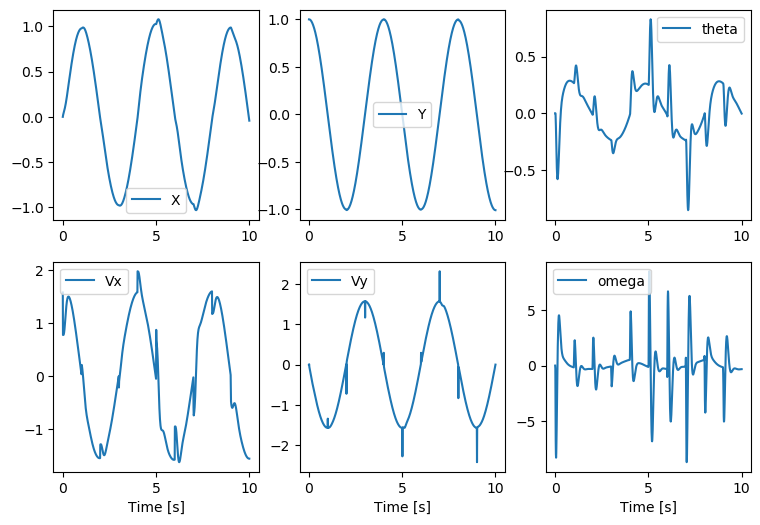

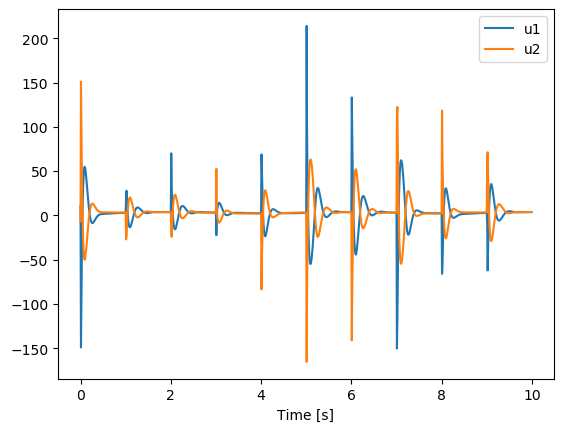

In [16]:
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

## Part 4 - iterative LQR

### Task 1 - reaching a vertical orientation

In [17]:
t = np.arange(0, 10.01, DELTA_T)
N = len(t) - 1

c1 = np.array([30, 0, 30, 0, 20, 0])
c2 = np.array([325, 0, 350, 0, 2000, 0])
d = np. array([8, 8])
c_mat = np.zeros((NUMBER_STATES, N))
s_cost_matrix = np.zeros((NUMBER_STATES, NUMBER_STATES, N))
d_cost_matrix = np.zeros((NUMBER_CONTROLS, NUMBER_CONTROLS, N))
for itr in range(N):
    if (itr >= 0) and (itr <= 50):
        c_mat[:, itr] = c2
        s_cost_matrix[:, :, itr] = np.diag(c2)
    elif(itr >= 475) and (itr <= 525):
        c_mat[:, itr] = c2
        s_cost_matrix[:, :, itr] = np.diag(c2)
    elif ((itr >= 450) and (itr <= 474)) or ((itr >= 525) and (itr <= 550)):
        c_mat[:, itr] = c1
        s_cost_matrix[:, :, itr] = np.diag(c1)
    elif (itr >= 950) and (itr <= N):
        c_mat[:, itr] = c2
        s_cost_matrix[:, :, itr] = np.diag(c2)
    else:
        c_mat[:, itr] = c1
        s_cost_matrix[:, :, itr] = np.diag(c1)
    
    d_cost_matrix[:, :, itr] = np.diag(d)

z_des = np.zeros((NUMBER_STATES, N + 1))
for index in range(z_des.shape[1]):
    if (index >= 475) and (index <= 525):
        z_des[:, index] = [3, 0, 3, 0, (np.pi / 2), 0]
    elif ((index >= 450) and (index <= 474)) or ((index >= 526) and (index <= 550)):
        z_des[:, index] = [3, 0, 3, 0, 0, 0]
        
u_des = np.ones((NUMBER_CONTROLS, N)) * ((MASS * GRAVITY) / 2)

c_mat = np.transpose(c_mat)
z_des_c = np.transpose(z_des)
u_des_c = np.transpose(u_des)

In [18]:
def compute_cost(z, u, horizon_length):
    trajectory_cost = 0
    for i in range(horizon_length):
        trajectory_cost += (np.transpose(z[i] - z_des_c[i]) @ s_cost_matrix[:, :, i] @ (z[i] - z_des_c[i])) + (np.transpose(u[i] - u_des_c[i]) @ d_cost_matrix[:, :, i] @ (u[i] - u_des_c[i]))
    return trajectory_cost 

In [19]:
def get_quadratic_approximation_cost(z, u, horizon_length):
    q = np.empty((horizon_length + 1, NUMBER_STATES))
    r = np.empty((horizon_length, NUMBER_CONTROLS))
    Q = np.empty((horizon_length + 1, NUMBER_STATES, NUMBER_STATES))
    R = np.empty((horizon_length, NUMBER_CONTROLS, NUMBER_CONTROLS))
    
    for j in range(horizon_length):   
        q[j, :] = np.array([2 * c_mat[j, 0] * (z[j, 0] - z_des_c[j, 0]), 2 * c_mat[j, 1] * (z[j, 1] - z_des_c[j, 1]), 2 * c_mat[j, 2] * (z[j, 2] - z_des_c[j, 2]), 2 * c_mat[j, 3] * (z[j, 3] - z_des_c[j, 3]), 2 * c_mat[j, 4] * (z[j, 4] - z_des_c[j, 4]), 2 * c_mat[j, 5] * (z[j, 5] - z_des_c[j, 5])]).reshape(NUMBER_STATES,)
        Q[j, :] = np.array([[2 * c_mat[j, 0], 0, 0, 0, 0, 0], 
                            [0, 2 * c_mat[j, 1], 0, 0, 0, 0], 
                            [0, 0, 2 * c_mat[j, 2], 0, 0, 0], 
                            [0, 0, 0, 2 * c_mat[j, 3], 0, 0], 
                            [0, 0, 0, 0, 2 * c_mat[j, 4], 0], 
                            [0, 0, 0, 0, 0, 2 * c_mat[j, 5]]])
        r[j, :] = np.array([2 * d[0] * (u[j, 0] - u_des_c[j, 0]), 2 * d[1] * (u[j, 1] - u_des_c[j, 1])]).reshape(NUMBER_CONTROLS,)
        R[j, :] = np.array([[2 * d[0], 0],
                            [0, 2 * d[1]]])

        index = j

    q[index + 1, :] = np.array([2 * c_mat[j, 0] * (z[j + 1, 0] - z_des_c[j + 1, 0]), 2 * c_mat[j, 1] * (z[j + 1, 1] - z_des_c[j + 1, 1]), 2 * c_mat[j, 2] * (z[j + 1, 2] - z_des_c[j + 1, 2]), 2 * c_mat[j, 3] * (z[j + 1, 3] - z_des_c[j + 1, 3]), 2 * c_mat[j, 4] * (z[j + 1, 4] - z_des_c[j + 1, 4]), 2 * c_mat[j, 5] * (z[j + 1, 5] - z_des_c[j + 1, 5])]).reshape(NUMBER_STATES,)
    Q[index + 1, :] = np.array([[2 * c_mat[j, 0], 0, 0, 0, 0, 0], 
                            [0, 2 * c_mat[j, 1], 0, 0, 0, 0], 
                            [0, 0, 2 * c_mat[j, 2], 0, 0, 0], 
                            [0, 0, 0, 2 * c_mat[j, 3], 0, 0], 
                            [0, 0, 0, 0, 2 * c_mat[j, 5], 0], 
                            [0, 0, 0, 0, 0, 2 * c_mat[j, 5]]])
    return q, r, Q, R

In [20]:
def solve_iLQR(A, B, Q, R, q, r, N):
    K_gains = []
    k_feedforward = []
    list_of_P = []
    list_of_p = []

    idx = 0
    for i in range(N, -1, -1):
        if (i == N):
            list_of_P.append(Q[i, :, :])
            list_of_p.append(q[i, :])
        else:
            K = -1 * (np.linalg.inv(R[i, :, :] + np.transpose(B[i]) @ list_of_P[idx] @ B[i])) @ np.transpose(B[i]) @ list_of_P[idx] @ A[i]
             
            P = Q[i, :, :] + np.transpose(A[i]) @ list_of_P[idx] @ A[i] + np.transpose(A[i]) @ list_of_P[idx] @ B[i] @ K

            k = -1 * (np.linalg.inv(R[i, :, :] + np.transpose(B[i]) @ list_of_P[idx] @ B[i])) @ ((np.transpose(B[i]) @ list_of_p[idx]) + r[i, :])

            p = q[i, :] + np.transpose(A[i]) @ list_of_p[idx] + np.transpose(A[i]) @ list_of_P[idx] @ B[i] @ k
            
            list_of_p.append(p)
            list_of_P.append(P)

            K_gains.append(K)
            k_feedforward.append(k)
            idx += 1
    
    K_gains.reverse()
    k_feedforward.reverse()
    K_gains = np.asarray(K_gains)
    k_feedforward = np.asarray(k_feedforward)
    return K_gains, k_feedforward

In [21]:
zstar = np.zeros((N + 1, NUMBER_STATES))
ustar = np.ones((N, NUMBER_CONTROLS)) * (MASS * GRAVITY) / 2
u_n = ustar
prev_cost = np.inf

while (True):
    alpha = 1
    q, r, Q, R = get_quadratic_approximation_cost(zstar, ustar, N)
    list_of_A = []
    list_of_B = []
    for k in range(N):
        st = zstar[k]
        con = ustar[k]
        a, b = get_linearization(st, con)
        list_of_A.append(a)
        list_of_B.append(b)

    K_gains, k_feedforward = solve_iLQR(list_of_A, list_of_B, Q, R, q, r, N)

    while (alpha > 0.01):
        z_n = np.zeros((N + 1, NUMBER_STATES))
        for idx in range(K_gains.shape[0]):
            u_n[idx, :] = ustar[idx, :] + (K_gains[idx, :, :] @ (z_n[idx, :] - zstar[idx, :])) + (alpha * (k_feedforward[idx, :]))
            z_n[idx + 1, :] = get_next_state(z_n[idx, :], u_n[idx, :])

        curr_cost = compute_cost(z_n, u_n, N)
        if (curr_cost < prev_cost):
            break
        else:
            alpha = alpha / 2
            
    zstar = z_n
    ustar = u_n

    if ((prev_cost - curr_cost) < 1):
        break
    
    prev_cost = curr_cost
    
zstar = np.transpose(zstar)
ustar = np.transpose(ustar)

In [22]:
state = zstar
u = ustar
animate_robot(state, u) 

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAe+9tZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABLVZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKH8XjN/AAAAwAAt4AXsAwgCqgMKj6I
dndnTzAIiR6+OnDbVkTjpPexGHLjoXY30hkXEhSE9kEKIJNbrApCI4G73ihHZi4T1K1iog5Wc0p6
pLHThCwCmnYhSqYpYbTo2n5tZjl9Sersc3rmxTCU1aG5ejWlf2ZiBPtJ6vuZEf6FCWPekrjf3iOx
g9nYeAC3//ekaJ6Uup8pEnX74AtF5miPCXmGYp1VgIlMhblKE1f5XLlxb1HUXmuG+fEgDCAJNggr
SWMoFVS8OFpaDDMvSO64pmzh6vHDoKtfmcA4i12uUsh7rwNZe/BI7LdbaaCmFlaKG6p3WlZZBOgL
c6Xh6KGqBk+DXTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlIHYXCzI57hN1GXk5AJs78
kL3L0uFeE8COidDOFd4yzkoe/7l2h6wEKOz7uFgABdAAABgT/XL0eR8k6J3lRIGcTlhh/LgQemvB
9LeOOPbS/io9bEKpktMzUsr2rH7n7gn+AW5ayX7+OPXTsJWi5Af6cl+Qnz0uW+DYBLS5p2thXpov
CDk56tcwW0pgAmn5ff2hXXmI9LQE3pWGz9avZjnRjG4VNxvRD6MJBuoGFZz0TZh4HejXX+Xr6AY1
NtLhG5Dt0FFT7heDy2T/J56stCiLolYaEC4Lsf3Ba/m1qzWfMEIyANp7aDPKoMHvT9ZjAKv7FBZX
Xxf0d3g8dTn4pTf1GQPGRmfytUQyQGmaJAtChL15m3Bfb2TtW1+3gzSZ1S1Rg4BH5ZPE24z39rF9
EoPALouyjq/tksmA0xnvlOq2NQQ7nQGy++HnWaMv68jeZLfIspnHkGYLlaiHH8+7/gxXkppoqbbV
zGkbOLAlUxuB3Hkcp5ozwRFJEkffYokAAAMAAAMAAAMAAAU6K2WUArTaxeJ+FAI6eDOlC41QrK3f
HaPOA6Tkh7/DwxsYaebi6Zz/tc3X0+AhNf+/w/jFcrRNyaPOOEcBzxEuEPILst0ElfjGP5v3AH5X
yXBfc7WidnYCZrsawbrLqWTm4QgoAdRgLV0U555i/86kNOiHr46Nw6torKk1r7mNtZ/T/Xe6+E7+
EjZHG90CyaEPaGS3j/5mYHg3MA5rbEmvPGuisLgNZSWC1YVoTVeDeOdKGR4E2btWR6qv3qENxUyo
8iZFN4bCV4sg7yVTfCv+Q1WwrD7TEkA1RBJAbcuHVY/8Cr9g1yT55JNil2P/LNaXYUIQw3dbuA0A
Pk8XHLIUBKF97ZANsF7aGYwAx5/lXZ4VehoU4xcE8RhlLFM4cpp+d+Knot6APk5kCQAAbt3cswf9
8VQgESJkJJAA+SWSIQAb8pg7QEFCMiI9fXlA5RchbcN6cnpCg4tPCQQUQzEYuMw5TSwFBoseTShV
DvUG8HqMeInlNnSc35dg6qXdjP7Eua7hazlhmTTc0VS9ZoYRvwPFL4tfuY06N4iDUZjIQbg7U70s
URUHGExDjY1GOP+WaHftiuowiY2wZc2zZBbJN6IPGA+CheMfDJvd1NLOEP0ozXYw03vnZs/W9gCx
b1e23z/vXgKv7enJbogTUHDv4z1gABhP1/SXYHRQsyIRRJnZQHPe5lQLlhk7ZJsEYIzSVMlJeek+
SyiSt0lurw+wWSMU6ek23ZY+4t+OO+LOBc440+D65iGCaY12Mo62QSRuIyOPrpSHL1Ms/r+T68E5
hrb4xy99bkV2XzIsD5hKbX839f5IRid5vjrFQYrfEsU5YFsMypirxPu/i9/x3QEKO7zbBAbohpDn
Rqx2iDHSG7RQWmLnXQao9tuKo39+7cfdHCcbLASU5acP+JRtitWU4P3fBwAAHWOaiO1fjyAAAkrf
Z1QJmw0ALFXyG1Un0dEgJOL1g/uaPPC+ChrgHFNkVKEihOTdPMvKITfFq10eRSh5HN94HC15g35I
Jpsc9lgJH2C0od/SzqevucoFnon6vjVTEdRy2JMuAuIdyx0tjEVnlNSdAH4w+1axbHGskqnzRTNS
o+AdQrzGNpourW6O4wiR7VSUYR6LJw2NuMYyTnsGU+u8cWlQNEZzp2Am89JXSmVgFTE7+sjvt4X9
WpOuj6EDESSEN01s8/Wae6yjJVl/pG+1cPdxm51+MU0gcBByNB+1KwrqPj4njMAv4+eyrw0Olf0W
IxVKdrOlPV/5yIiqoqgRtpiJzywdV+w015AMwGCmml0UFti02UTeUTw7foCdkd12M9eZ8gCrY/W8
HhIFr9ij8S6xWB6sLZGgx9qEiDIwhXxCjNBQwvH47OuB0jtKloDsZvSGBy5zMd0j98MnRiRfmaRR
C2iP9v3cXQTdiw0Esd0B79gy4iHUysDJHg+tog3HI1VqTYIDgAYBOYabuwLW8sUaPe5/fCSvT60F
r3UfwcnGvKGIAWKxmpyiJqH8lXMTMhfoUp2MNKqTMWFR7JYHJ6Ud7YLXTnKMVxWwbp73rq1rBO/3
ibvFb8LhUPbik4ChLLiUdtOrGhNBx/mPn4JpcnOm0Nr/X1z2XBm5r9o4EDGSTid/kt9cg5O0PPeX
Q+m/ab+/WZa0iLrEkIZA63//wc00NaUhqbvcHIcvzhNxDuYKgxsHc9DDMgrpQKfAzSNSF4JNNs9e
7OjQdLECAKJqL8bXUzeNQ23NUyqqRjKGiRfAz4B6UDw+h+1iTytim5YW76hPN/yCZ/0jgkDj6/Ii
d2EOjLe2HdIYyP1fXpjnJyt8gWnRf9rr/1OqbKx5lt6EwjMKZwby2196utL6TGw0b1QjM0GHTH8h
qzkkvevbvxpJ0ODbYhvH5e2hm7rLy2NqeYlYcTOhPFGf4yF/p3lhHW8Ea6ocqCrjwjE2B9C4AAAD
Ahc239zQ50AAAAMAAD42w

Text(0.5, 0, 'Time [s]')

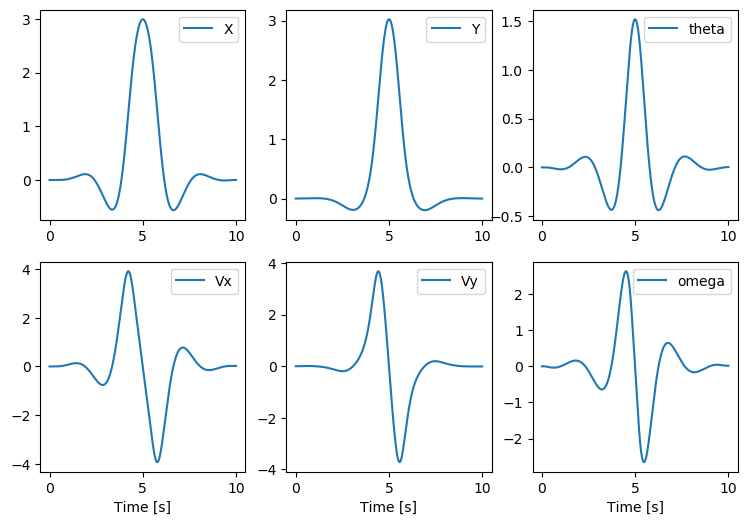

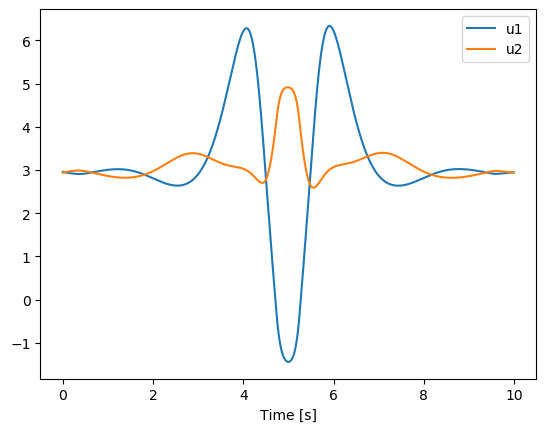

In [23]:
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')

### Task 2 - doing a full flip

In [24]:
t = np.arange(0, 10.01, DELTA_T)
N = len(t) - 1

pos1 = np.array([1.5, 0, 3, 0, (np.pi), 0])
pos2 = np.array([3, 0, 0, 0, (2 * np.pi), 0])

c1 = np.array([470, 0, 1000, 0, 100, 0])
c2 = np.array([175, 0, 175, 0, 50, 0])
d = np. array([50, 50])

c_mat = np.zeros((NUMBER_STATES, N))
s_cost_matrix = np.zeros((NUMBER_STATES, NUMBER_STATES, N))
d_cost_matrix = np.zeros((NUMBER_CONTROLS, NUMBER_CONTROLS, N))


u_des = np.ones((NUMBER_CONTROLS, N)) * ((MASS * GRAVITY) / 2)

z_des = np.zeros((NUMBER_STATES, N + 1))
for index in range(z_des.shape[1]):
    if ((index >= 455) and (index <= 520)):
        z_des[:, index] = pos1
    elif (index >= 521):
        z_des[:, index] = pos2

for itr in range(N):
    if (itr >= 455):
        c_mat[:, itr] = c1
        s_cost_matrix[:, :, itr] = np.diag(c1)
    else:
        c_mat[:, itr] = c2
        s_cost_matrix[:, :, itr] = np.diag(c2)
    
    d_cost_matrix[:, :, itr] = np.diag(d)

c_mat = np.transpose(c_mat)
z_des_c = np.transpose(z_des)
u_des_c = np.transpose(u_des)

In [25]:
def compute_cost(z, u, horizon_length):
    trajectory_cost = 0
    for i in range(horizon_length):
        trajectory_cost += (np.transpose(z[i] - z_des_c[i]) @ s_cost_matrix[:, :, i] @ (z[i] - z_des_c[i])) + (np.transpose(u[i] - u_des_c[i]) @ d_cost_matrix[:, :, i] @ (u[i] - u_des_c[i]))
    return trajectory_cost 

In [26]:
def get_quadratic_approximation_cost(z, u, horizon_length):
    q = np.empty((horizon_length + 1, NUMBER_STATES))
    r = np.empty((horizon_length, NUMBER_CONTROLS))
    Q = np.empty((horizon_length + 1, NUMBER_STATES, NUMBER_STATES))
    R = np.empty((horizon_length, NUMBER_CONTROLS, NUMBER_CONTROLS))
    
    for j in range(horizon_length):   
        q[j, :] = np.array([2 * c_mat[j, 0] * (z[j, 0] - z_des_c[j, 0]), 2 * c_mat[j, 1] * (z[j, 1] - z_des_c[j, 1]), 2 * c_mat[j, 2] * (z[j, 2] - z_des_c[j, 2]), 2 * c_mat[j, 3] * (z[j, 3] - z_des_c[j, 3]), 2 * c_mat[j, 4] * (z[j, 4] - z_des_c[j, 4]), 2 * c_mat[j, 5] * (z[j, 5] - z_des_c[j, 5])]).reshape(NUMBER_STATES,)
        Q[j, :] = np.array([[2 * c_mat[j, 0], 0, 0, 0, 0, 0], 
                            [0, 2 * c_mat[j, 1], 0, 0, 0, 0], 
                            [0, 0, 2 * c_mat[j, 2], 0, 0, 0], 
                            [0, 0, 0, 2 * c_mat[j, 3], 0, 0], 
                            [0, 0, 0, 0, 2 * c_mat[j, 4], 0], 
                            [0, 0, 0, 0, 0, 2 * c_mat[j, 5]]])
        r[j, :] = np.array([2 * d[0] * (u[j, 0] - u_des_c[j, 0]), 2 * d[1] * (u[j, 1] - u_des_c[j, 1])]).reshape(NUMBER_CONTROLS,)
        R[j, :] = np.array([[2 * d[0], 0],
                            [0, 2 * d[1]]])
        
        index = j
                            
    q[index + 1, :] = np.array([2 * c_mat[j, 0] * (z[j + 1, 0] - z_des_c[j + 1, 0]), 2 * c_mat[j, 1] * (z[j + 1, 1] - z_des_c[j + 1, 1]), 2 * c_mat[j, 2] * (z[j + 1, 2] - z_des_c[j + 1, 2]), 2 * c_mat[j, 3] * (z[j + 1, 3] - z_des_c[j + 1, 3]), 2 * c_mat[j, 4] * (z[j + 1, 4] - z_des_c[j + 1, 4]), 2 * c_mat[j, 5] * (z[j + 1, 5] - z_des_c[j + 1, 5])]).reshape(NUMBER_STATES,)
    Q[index + 1, :] = np.array([[2 * c_mat[j, 0], 0, 0, 0, 0, 0], 
                                [0, 2 * c_mat[j, 1], 0, 0, 0, 0], 
                                [0, 0, 2 * c_mat[j, 2], 0, 0, 0], 
                                [0, 0, 0, 2 * c_mat[j, 3], 0, 0], 
                                [0, 0, 0, 0, 2 * c_mat[j, 5], 0], 
                                [0, 0, 0, 0, 0, 2 * c_mat[j, 5]]])
    return q, r, Q, R

In [27]:
def solve_iLQR(A, B, Q, R, q, r, N):
    K_gains = []
    k_feedforward = []
    list_of_P = []
    list_of_p = []

    idx = 0
    for i in range(N, -1, -1):
        if (i == N):
            list_of_P.append(Q[i, :, :])
            list_of_p.append(q[i, :])
        else:
            K = -1 * (np.linalg.inv(R[i, :, :] + np.transpose(B[i]) @ list_of_P[idx] @ B[i])) @ np.transpose(B[i]) @ list_of_P[idx] @ A[i]
             
            P = Q[i, :, :] + np.transpose(A[i]) @ list_of_P[idx] @ A[i] + np.transpose(A[i]) @ list_of_P[idx] @ B[i] @ K

            k = -1 * (np.linalg.inv(R[i, :, :] + np.transpose(B[i]) @ list_of_P[idx] @ B[i])) @ ((np.transpose(B[i]) @ list_of_p[idx]) + r[i, :])

            p = q[i, :] + np.transpose(A[i]) @ list_of_p[idx] + np.transpose(A[i]) @ list_of_P[idx] @ B[i] @ k
            
            list_of_p.append(p)
            list_of_P.append(P)

            K_gains.append(K)
            k_feedforward.append(k)
            idx += 1
    
    K_gains.reverse()
    k_feedforward.reverse()
    K_gains = np.asarray(K_gains)
    k_feedforward = np.asarray(k_feedforward)
    return K_gains, k_feedforward

In [28]:
zstar = np.zeros((N + 1, NUMBER_STATES))
ustar = np.ones((N, NUMBER_CONTROLS)) * (MASS * GRAVITY) / 2
u_n = ustar
prev_cost = np.inf

while (True):
    alpha = 1
    q, r, Q, R = get_quadratic_approximation_cost(zstar, ustar, N)
    list_of_A = []
    list_of_B = []
    for k in range(N):
        st = zstar[k]
        con = ustar[k]
        a, b = get_linearization(st, con)
        list_of_A.append(a)
        list_of_B.append(b)

    K_gains, k_feedforward = solve_iLQR(list_of_A, list_of_B, Q, R, q, r, N)

    while (alpha > 0.01):
        z_n = np.zeros((N + 1, NUMBER_STATES))
        for idx in range(K_gains.shape[0]):
            u_n[idx, :] = ustar[idx, :] + (K_gains[idx, :, :] @ (z_n[idx, :] - zstar[idx, :])) + (alpha * (k_feedforward[idx, :]))
            z_n[idx + 1, :] = get_next_state(z_n[idx, :], u_n[idx, :])

        curr_cost = compute_cost(z_n, u_n, N)
        if (curr_cost < prev_cost):
            break
        else:
            alpha = alpha / 2
    
    zstar = z_n
    ustar = u_n

    if ((prev_cost - curr_cost) < 1):
        break
    
    prev_cost = curr_cost
    
zstar = np.transpose(zstar)
ustar = np.transpose(ustar)

In [29]:
state = zstar
u = ustar
animate_robot(state, u) 

<source type="video/mp4" src="data:video/mp4;base64,AAAAIGZ0eXBNNFYgAAACAE00ViBpc29taXNvMmF2YzEAAAAIZnJlZQAAeaBtZGF0AAACoQYF//+d
3EXpvebZSLeWLNgg2SPu73gyNjQgLSBjb3JlIDE2MSAtIEguMjY0L01QRUctNCBBVkMgY29kZWMg
LSBDb3B5bGVmdCAyMDAzLTIwMjAgLSBodHRwOi8vd3d3LnZpZGVvbGFuLm9yZy94MjY0Lmh0bWwg
LSBvcHRpb25zOiBjYWJhYz0xIHJlZj0zIGRlYmxvY2s9MTowOjAgYW5hbHlzZT0weDM6MHgxMTMg
bWU9aGV4IHN1Ym1lPTcgcHN5PTEgcHN5X3JkPTEuMDA6MC4wMCBtaXhlZF9yZWY9MSBtZV9yYW5n
ZT0xNiBjaHJvbWFfbWU9MSB0cmVsbGlzPTEgOHg4ZGN0PTEgY3FtPTAgZGVhZHpvbmU9MjEsMTEg
ZmFzdF9wc2tpcD0xIGNocm9tYV9xcF9vZmZzZXQ9LTIgdGhyZWFkcz0xMiBsb29rYWhlYWRfdGhy
ZWFkcz0yIHNsaWNlZF90aHJlYWRzPTAgbnI9MCBkZWNpbWF0ZT0xIGludGVybGFjZWQ9MCBibHVy
YXlfY29tcGF0PTAgY29uc3RyYWluZWRfaW50cmE9MCBiZnJhbWVzPTMgYl9weXJhbWlkPTIgYl9h
ZGFwdD0xIGJfYmlhcz0wIGRpcmVjdD0xIHdlaWdodGI9MSBvcGVuX2dvcD0wIHdlaWdodHA9MiBr
ZXlpbnQ9MjUwIGtleWludF9taW49MTAgc2NlbmVjdXQ9NDAgaW50cmFfcmVmcmVzaD0wIHJjX2xv
b2thaGVhZD00MCByYz1jcmYgbWJ0cmVlPTEgY3JmPTIzLjAgcWNvbXA9MC42MCBxcG1pbj0wIHFw
bWF4PTY5IHFwc3RlcD00IGlwX3JhdGlvPTEuNDAgYXE9MToxLjAwAIAAABLKZYiEABH//veIHzLL
afk613IR560urR9Q7kZxXqS9/iAAAAMAAAMAAAMACpJYniKH8XjN/AAAAwAAt4AXsAwgCqgMKj6I
dndnTzAIiR6+OnDbVkTjpPexGHLjoXY30hkXEhSE9kEKIJNbrApCI4G73ihHZi4T1K1iog5Wc0p6
pLHThCwCmnYhSqYpYbTo2n5tZjl9Sersc3rmxTCU1aG5ejWlf2ZiBPtJ6vuZEf6FCWPekrjf3iOx
g9nYeAC3//ekaJ6Uup8pEnX74AtF5miPCXmGYp1VgIlMhblKE1f5XLlxb1HUXmuG+fEgDCAJNggr
SWMoFVS8OFpaDDMvSO64pmzh6vHDoKtfmcA4i12uUsh7rwNZe/BI7LdbaaCmFlaKG6p3WlZZBOgL
c6Xh6KGqBk+DXTIvzmnGdaE/vYVZrpQqE5tWlH1wLzpsCVXhaMhwyKlIHYXCzI57hN1GXk5AJs78
kL3L0uFeE8COidDOFd4yzkoe/7l2h6wEKOz7uFgABdAAABgT/XL0eR8k6J3lRIGcTlhh/LgQemvB
9LeOOPbS/io9bEKpktMzUsr2rH7n7gn+AW5ayX7+OPXTsJWi5Af6cl+Qnz0uW+DYBLS5p2thXpov
CDk56tcwW0pgAmn5ff2hXXmI9LQE3pWGz9avZjnRjG4VNxvRD6MJBuoGFZz0TZh4HejXX+Xr6AY1
NtLhG5Dt0FFT7heDy2T/J56stCiLolYaEC4Lsf3Ba/m1qzWfMEIyANp7aDPKoMHvT9ZjAKv7FBZX
Xxf0d3g8dTn4pTf1GQPGRmfytUQyQGmaJAtChL15m3Bfb2TtW1+3gzSZ1S1Rg4BH5ZPE24z39rF9
EoPALouyjq/tksmA0xnvlOq2NQQ7nQGy++HnWaMv68jeZLfIspnHkGYLlaiHH8+7/gxXkppoqbbV
zGkbOLAlUxuB3Hkcp5ozwRFJEkffYokAAAMAAAMAAAMAAAU6K2WUArTaxeJ+FAI6eDOlC41QrK3f
HaPOA6Tkh7/DwxsYaebi6Zz/tc3X0+AhNf+/w/jFcrRNyaPOOEcBzxEuEPILst0ElfjGP5v3AH5X
yXBfc7WidnYCZrsawbrLqWTm4QgoAdRgLV0U555i/86kNOiHr46Nw6torKk1r7mNtZ/T/Xe6+E7+
EjZHG90CyaEPaGS3j/5mYHg3MA5rbEmvPGuisLgNZSWC1YVoTVeDeOdKGR4E2btWR6qv3qENxUyo
8iZFN4bCV4sg7yVTfCv+Q1WwrD7TEkA1RBJAbcuHVY/8Cr9g1yT55JNil2P/LNaXYUIQw3dbuA0A
Pk8XHLIUBKF97ZANsF7aGYwAx5/lXZ4VehoU4xcE8RhlLFM4cpp+d+Knot6APk5kCQAAbt3cswf9
8VQgESJkJJAA+SWSIQAb8pg7QEFCMiI9fXlA5RchbcN6cnpCg4tPCQQUQzEYuMw5TSwFBoseTShV
DvUG8HqMeInlNnSc35dg6qXdjP7Eua7hazlhmTTc0VS9ZoYRvwPFL4tfuY06N4iDUZjIQbg7U70s
URUHGExDjY1GOP+WaHftiuowiY2wZc2zZBbJN6IPGA+CheMfDJvd1NLOEP0ozXYw03vnZs/W9gCx
b1e23z/vXgKv7enJbogTUHDv4z1gABhP1/SXYHRQsyIRRJnZQHPe5lQLlhk7ZJsEYIzSVMlJeek+
SyiSt0lurw+wWSMU6ek23ZY+4t+OO+LOBc440+D65iGCaY12Mo62QSRuIyOPrpSHL1Ms/r+T68E5
hrb4xy99bkV2XzIsD5hKbX839f5IRid5vjrFQYrfEsU5YFsMypirxPu/i9/x3QEKO7zbBAbohpDn
Rqx2iDHSG7RQWmLnXQao9tuKp4GcMmzFRKJKdmiECW9tYmTwPK/VZkbzJ+AACxxdDlTYvqgAAPCN
wdDZJecADljaxx8T61mQEnF6wf3NHnhfBQ1wDimyKlCRQnJunmXlEJvi1a6PIpQ8jm+8Dha4gjOi
a1uOI4SOgJ+jjF7fyCGTxhBPC+cPJNIEa4SPR0hPF/X+ZnAEG7Q9Z+QKK5voE9r1ObP2SU8znCMU
VIN7XHueIxxN5Zwb/jIaX8Q6W39Q1v3W/uYoOX0JXqKQZaRU54FedVARczOmvJp3X6RV6y7h0A2/
Sup6ARQT0t5HDmV+q8/3tJCldm/4AspxRbYJjSAAOVvvINnxu0PKpqj/lkvm6ZVp0XhoxVKdrOlR
R40x08MrlgRtpiLbyvYOe46Jq3vwGCmml0woNVfUTfzpetMm88ud5F4WdRZ1UMm8Tqp/qPcz9fZB
fdqarVW7IUer1nPApzy2Fj6mDGTJCfTNdjTZBroZ7RVLBPhsXtqbrQY33GU2T1PJWHmdl19JOrEz
Z6C2n7qHpySZUTrSI4xXNnT7yf7hg99f1TDeEyvaZXCbSFsQVmYCGNUGlGSpTAWoc4ysZ6EK+NEX
lMxcZzpAFM0AXhF+WeeD0HIY7cZjMU74OsEHF6IGrp6aSZuHHt4nzXHzzBENDRfqRcvK4qiMzUe2
PY7OaaqT4jjhnuZeE7YpmxK9LLRdiZmBAgMzLt/2rDaW0CwJvZOBWUVLiEmPJsuJrngvuy57oGzK
xhH8z0UFVko5+olzvnvsS2RU/c8smRy05r3TFXYgfQnSaaCkOOSq7J46Lajz+2jfR2X+pE4OkIA9
jkhX9gaT8tSKmQGCndplegMCqr6YYf0D8hOEBem1A/ur2qA8JUmzTdbxmSDE8+x+2JP3j5dNO+R9
+T/6W9BsT79rypCPLfJa76lxqkCDPsyd/UIXYcvBCeYXCSTgRKeQEQyCFhxV63pSIHJznKn+PAt0
hgKQR5dswGXkuklgXe20cIbTFMlmBDgA6gFaNl34HFa9gycynoZ+dxAAA7XeKyABvu8fEQxTieN8
EgfHrtiVytOuiv0Cuua/A

Text(0.5, 0, 'Time [s]')

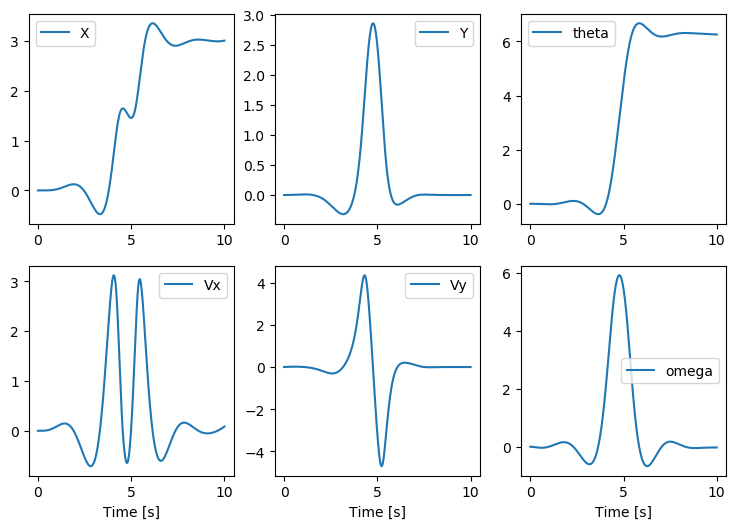

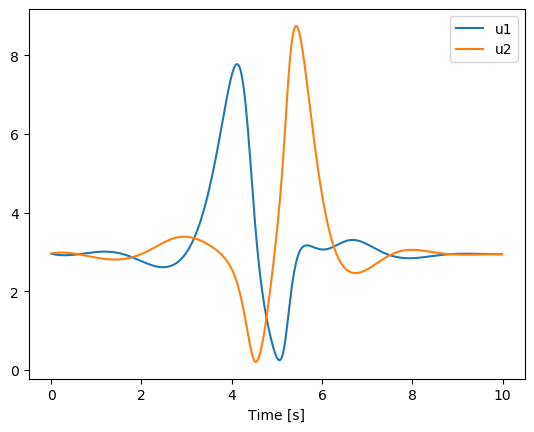

In [30]:
plt.figure(figsize=[9,6])

plt.subplot(2,3,1)
plt.plot(t, state[0,:])
plt.legend(['X'])

plt.subplot(2,3,2)
plt.plot(t, state[2,:])
plt.legend(['Y'])

plt.subplot(2,3,3)
plt.plot(t, state[4,:])
plt.legend(["theta"])

plt.subplot(2,3,4)
plt.plot(t, state[1,:])
plt.legend(['Vx'])
plt.xlabel('Time [s]')

plt.subplot(2,3,5)
plt.plot(t, state[3,:])
plt.legend(['Vy'])
plt.xlabel('Time [s]')

plt.subplot(2,3,6)
plt.plot(t, state[5,:])
plt.legend(['omega'])
plt.xlabel('Time [s]')

# we can also plot the control
plt.figure()
plt.plot(t[:-1], u.T)
plt.legend(['u1', 'u2'])
plt.xlabel('Time [s]')